# Fastai Experimentation

This notebook is intended to be used after running the google image scraper in this repo. To get started follow the README.md in this repo, then come back after all the csv files have been generated, labeled, and saved in the data_csv directory.

In [1]:
from fastai.vision import *
import os
path = Path(f'../data_csv')

### Define Experiment
Running this cell will save the images and any saved models in a directory with the experiments name.

In [2]:
experiment = 'tree_leaves'

In [3]:
dest_path = Path(f'../data')
img_path = dest_path/experiment

## Download images per class
The google scraper will save the csv files labeled by the classes you want to train. These csv files will be nested in a directory with the labeled classname. For example:
```
data_csv/
    ash_tree/
        ash_tree.csv
    bigleaf_maple/
        bigleaf_maple.csv
        ...
```
The images will be saved in a data directory nested under experiment name and class name:
```
data/
    trees/
        ash_tree/
            *.jpeg
```

In [4]:
for folder in os.listdir('../data_csv'):
    file = path/folder/os.listdir(f'../data_csv/{folder}')[0]
    dest = img_path/folder
    dest.mkdir(parents=True, exist_ok=True)
    print(folder, '   ',file, ' dest', dest)
    download_images(file, dest, max_pics=200)

## Verify Images can be Trained

In [5]:
classes = os.listdir(f'../data/{experiment}')
for c in classes:
    print(c)
    verify_images(img_path/c, delete=True, max_size=500)

## Create ImageDataBunch for Training

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(img_path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

## Show Classes to be Trained

In [7]:
data.classes

['Douglas-fir',
 'Oregon_white_oak',
 'Pacific_madrone',
 'Ponderosa_pine',
 'Scouler_willow',
 'Western_flowering_dogwood',
 'Western_hemlock',
 'ash_tree',
 'bigleaf_maple',
 'bitter_cherry',
 'black_cottonwood',
 'black_hawthorn',
 'cascara',
 'grand_fir',
 'quaking_aspen',
 'rigid_willow']

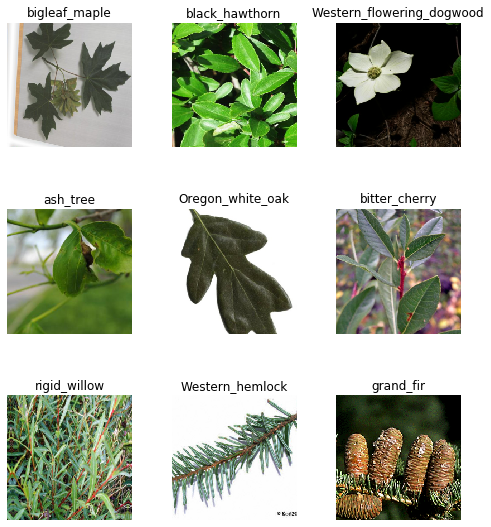

In [8]:
data.show_batch(rows=3, figsize=(7,8))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Douglas-fir',
  'Oregon_white_oak',
  'Pacific_madrone',
  'Ponderosa_pine',
  'Scouler_willow',
  'Western_flowering_dogwood',
  'Western_hemlock',
  'ash_tree',
  'bigleaf_maple',
  'bitter_cherry',
  'black_cottonwood',
  'black_hawthorn',
  'cascara',
  'grand_fir',
  'quaking_aspen',
  'rigid_willow'],
 16,
 1177,
 294)

In [10]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy], callback_fns=[partial(callbacks.EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=5)])

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


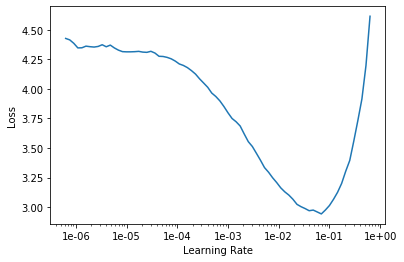

In [12]:
learn.recorder.plot()

In [13]:
lr=3e-3

In [14]:
learn.fit_one_cycle(4, max_lr=slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.157420,1.807180,0.469388,0.530612,00:08
1,2.223573,1.581890,0.435374,0.564626,00:08
2,1.701092,1.471829,0.421769,0.578231,00:08
3,1.330146,1.425046,0.414966,0.585034,00:08


In [15]:
interp = ClassificationInterpretation.from_learner(learn)

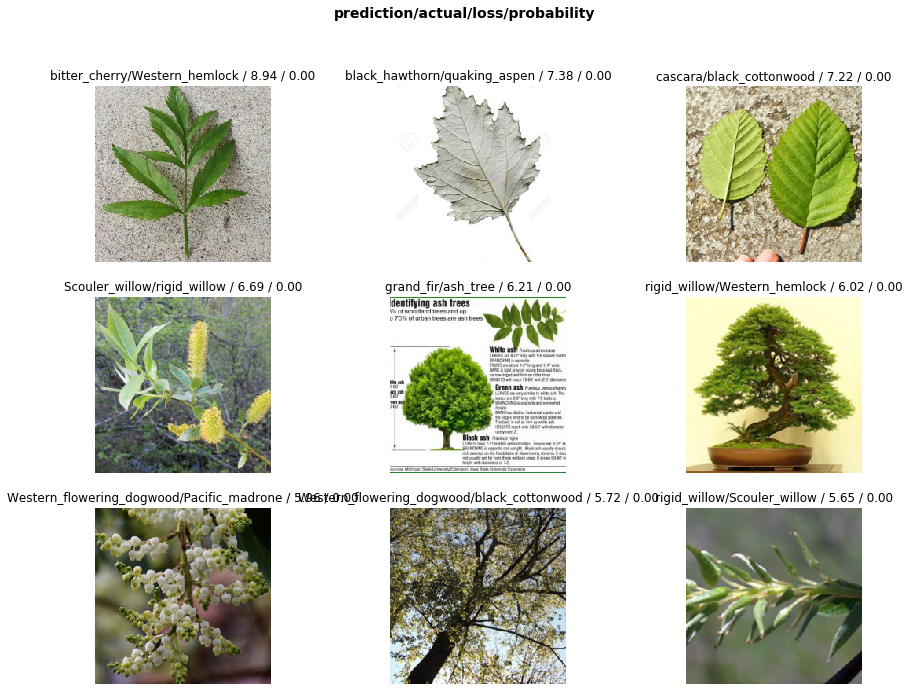

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

## Save Model and Unfreeze Layers

In [17]:
learn.save('stage-1')

In [18]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


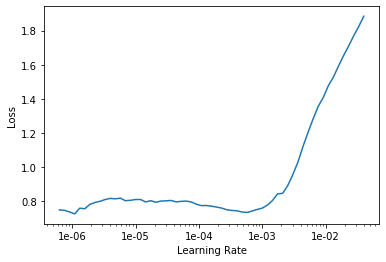

In [20]:
learn.recorder.plot()

In [21]:
starting_lr = 3e-4

## Train All Layers

In [22]:
learn.fit_one_cycle(150, max_lr=slice(starting_lr,lr/5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.782159,1.370547,0.401361,0.598639,00:10
1,0.690716,1.325985,0.394558,0.605442,00:11
2,0.639786,1.276296,0.380952,0.619048,00:11
3,0.579613,1.252861,0.370748,0.629252,00:11
4,0.508601,1.241859,0.377551,0.622449,00:11
5,0.452533,1.238007,0.367347,0.632653,00:10
6,0.403716,1.239284,0.340136,0.659864,00:10
7,0.345298,1.240748,0.326531,0.673469,00:11
8,0.294126,1.260659,0.336735,0.663265,00:11
9,0.258619,1.273417,0.340136,0.659864,00:11


Epoch 11: early stopping
